In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [116]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from collections import defaultdict

from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [117]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/train.csv')
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [118]:
#Breif info of the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

0    0.57034
1    0.42966
Name: target, dtype: float64

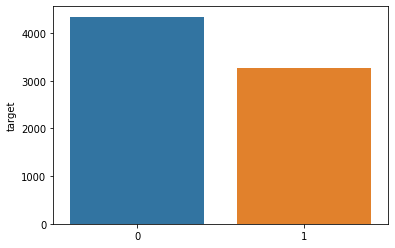

In [119]:
#Distribution of 'target'
sns.barplot(df_train['target'].value_counts().index, df_train['target'].value_counts())
df_train['target'].value_counts(1)

In [120]:
#common keywords happen in real-diaster tweet and fake-diaster tweet

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

#the eleventh common keyowrds in real_diaster is 'bombing', with target_mean : 0.931034
#append the top 10 keywords happened in real_diaster tweet
#same process on keyword_fake

keyword_real = []
for kw in df_train.query('target_mean > 0.93104').keyword:
    if kw not in keyword_real:
        keyword_real.append(kw)
        
keyword_fake = []
for kw in df_train.query('target_mean < 0.0625').keyword:
    if kw not in keyword_fake:
        keyword_fake.append(kw)

#output
#keyword_real = ['debris','derailment','oil%20spill','outbreak','suicide%20bomber','suicide%20bombing','typhoon','wreckage']
#keyword_fake = ['aftershock','blazing',blew%20up','body%20bag','body%20bags','electrocute','panicking','ruin','screaming','traumatised']

In [121]:
#number of words in a tweet
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

#numbers of punctutaion 
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([y for y in str(x) if y in string.punctuation]))

#characters in tweets
df_train['characters_count'] = df_train['text'].apply(lambda x: len(str(x)))

<AxesSubplot:xlabel='word_count', ylabel='Density'>

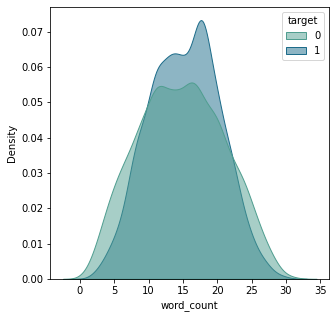

In [122]:
fig, axes = plt.subplots(figsize=(5,5))
sns.kdeplot(data=df_train, x='word_count', hue='target', fill=True, common_norm=False, palette="crest",alpha=.5,)

<AxesSubplot:xlabel='punctuation_count', ylabel='Density'>

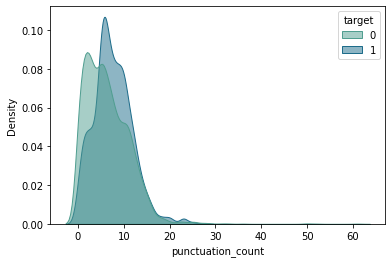

In [123]:
sns.kdeplot(data=df_train, x='punctuation_count', hue='target', fill=True, common_norm=False, palette="crest",alpha=.5,)

<AxesSubplot:xlabel='characters_count', ylabel='Density'>

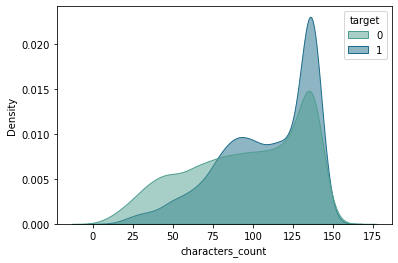

In [124]:
sns.kdeplot(data=df_train, x='characters_count', hue='target', fill=True, common_norm=False, palette="crest",alpha=.5,)

In [125]:
#analyze common stopwords 
#using the stopwords library from NLTK
corpus_fake=[]
for x in df_train[df_train['target']==0]['text'].str.split():
    for i in x:
        corpus_fake.append(i)
        
corpus_real=[]
for x in df_train[df_train['target']==1]['text'].str.split():
    for i in x:
        corpus_real.append(i)

stops = set(stopwords.words('english'))

dic_fake = defaultdict(int)
dic_real = defaultdict(int)

for word in corpus_fake:
    if word in stops:
        dic_fake[word]+=1
        
for word in corpus_real:
    if word in stops:
        dic_real[word]+=1

In [126]:
#The most common stopwords in real and fake diaster tweet
print(sorted(dic_fake.items(),key=lambda x:x[1], reverse=True)[:10])
print(sorted(dic_real.items(),key=lambda x:x[1], reverse=True)[:10])

[('the', 1524), ('a', 1115), ('to', 1099), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452), ('my', 442)]
[('the', 1051), ('in', 1037), ('of', 888), ('a', 730), ('to', 706), ('and', 462), ('on', 386), ('for', 368), ('is', 302), ('at', 273)]


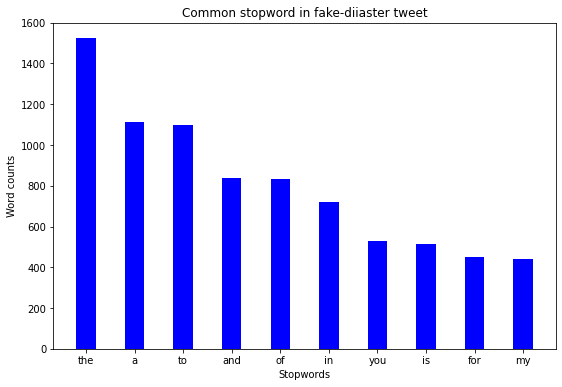

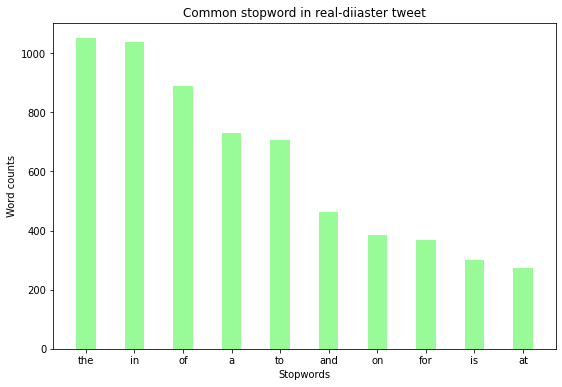

In [127]:
#unpacking the dict using operator *
temp1 = sorted(dic_fake.items(),key=lambda x:x[1], reverse=True)[:10]
temp2 = sorted(dic_real.items(),key=lambda x:x[1], reverse=True)[:10]

x1,y1=zip(*temp1)
x2,y2=zip(*temp2)

plt.figure(figsize=(9,6))
 
# creating the bar plot
plt.bar(x1, y1, color ='blue',
        width = 0.4)
 
plt.xlabel("Stopwords")
plt.ylabel("Word counts")
plt.title("Common stopword in fake-diiaster tweet")
plt.show()

plt.figure(figsize=(9,6))

plt.bar(x2, y2, color ='orange',
        width = 0.4)

plt.xlabel("Stopwords")
plt.ylabel("Word counts")
plt.title("Common stopword in real-diiaster tweet")
plt.show()

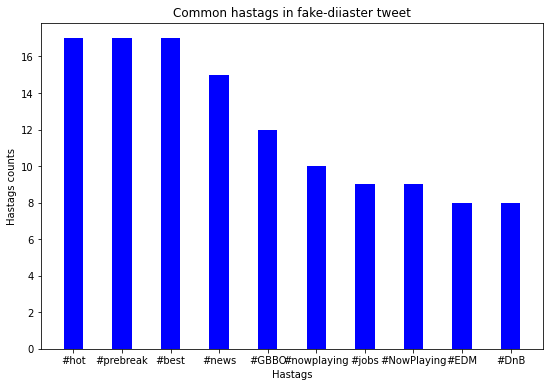

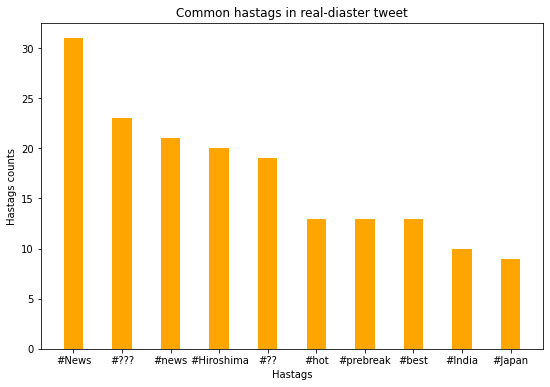

In [128]:
#analyze common hastags
from collections import Counter

hastags_real = [hastag for hastag in corpus_real if '#' in hastag]
hastags_fake = [hastag for hastag in corpus_fake if '#' in hastag]

temp1 = sorted(Counter(hastags_fake).items(),key=lambda x:x[1], reverse=True)[:10]
temp2 = sorted(Counter(hastags_real).items(),key=lambda x:x[1], reverse=True)[:10]

x1,y1=zip(*temp1)
x2,y2=zip(*temp2)

plt.figure(figsize=(9,6))
 
# creating the bar plot
plt.bar(x1, y1, color ='blue',
        width = 0.4)
 
plt.xlabel("Hastags")
plt.ylabel("Hastags counts")
plt.title("Common hastags in fake-diiaster tweet")
plt.show()

plt.figure(figsize=(9,6))

plt.bar(x2, y2, color ='orange',
        width = 0.4)

plt.xlabel("Hastags")
plt.ylabel("Hastags counts")
plt.title("Common hastags in real-diaster tweet")
plt.show()

In [129]:
#some of the hastages were not able capture when preparaing the dataset

# Data Cleaning

In [130]:
#Make text lowercase, remove text in square brackets,remove URLs,remove punctuation and remove words containing numbers, remove stopwords.
#Perform stemming using SnowballStemmer

In [131]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [132]:
#remove stopwords using the list of stopwords defined eariler in this notebook

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stops)
    return text

In [133]:
#stemmer = nltk.SnowballStemmer("english")
#
#def stemm_text(text):
#    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
#    return text

In [134]:
#Putting the functions together
def preprocess_data(text):
    text = clean_text(text)
    text = ' '.join(word for word in text.split(' ') if word not in stops)
    #text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [135]:
df_train['text_clean'] = df_train['text'].apply(preprocess_data)

In [136]:
df_train.head(5)

,id,keyword,location,text,target,target_mean,word_count,punctuation_count,characters_count,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,13,1,69,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,7,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,22,3,133,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,8,2,65,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,16,2,88,got sent photo ruby alaska smoke wildfires pou...


# Vectorization

In [137]:
texts = df_train['text_clean']
targets = df_train['target']

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

vocab_length = len(tokenizer.word_index) + 1
vocab_length

16702

In [138]:
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, padding='post')
padded

array([[4166,  724,  143, ...,    0,    0,    0],
       [  95,    5,  125, ...,    0,    0,    0],
       [1514, 1392, 1882, ...,    0,    0,    0],
       ...,
       [ 460, 1381,    0, ...,    0,    0,    0],
       [  17,  953, 2895, ...,    0,    0,    0],
       [ 112,  107,  411, ...,    0,    0,    0]], dtype=int32)

In [139]:
#put the word and its corresponding vectors into a dict
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [140]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
#embedding_matrix

# Baseline Model

In [141]:
#Building a baseline model and compare the performance of futhure models with this

word_counts = []
for sentence in texts:
    word_counts.append(len(sentence))

length_long_sentence = max(word_counts)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=128))  
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
X_train, X_test, y_train, y_test = train_test_split(padded, targets, test_size=0.25, random_state = 42)
history = model.fit(X_train, y_train, epochs = 5,batch_size = 32, validation_data = (X_test, y_test),verbose = 1)

Epoch 1/5
179/179 [==============================] - 36s 184ms/step - loss: 0.5175 - accuracy: 0.7581 - val_loss: 0.4214 - val_accuracy: 0.8214
Epoch 2/5
179/179 [==============================] - 32s 179ms/step - loss: 0.3685 - accuracy: 0.8482 - val_loss: 0.4202 - val_accuracy: 0.8241
Epoch 3/5
179/179 [==============================] - 33s 183ms/step - loss: 0.2793 - accuracy: 0.8881 - val_loss: 0.4452 - val_accuracy: 0.8188
Epoch 4/5
179/179 [==============================] - 33s 182ms/step - loss: 0.1795 - accuracy: 0.9328 - val_loss: 0.4970 - val_accuracy: 0.8009
Epoch 5/5
179/179 [==============================] - 32s 178ms/step - loss: 0.1173 - accuracy: 0.9584 - val_loss: 0.6251 - val_accuracy: 0.7621


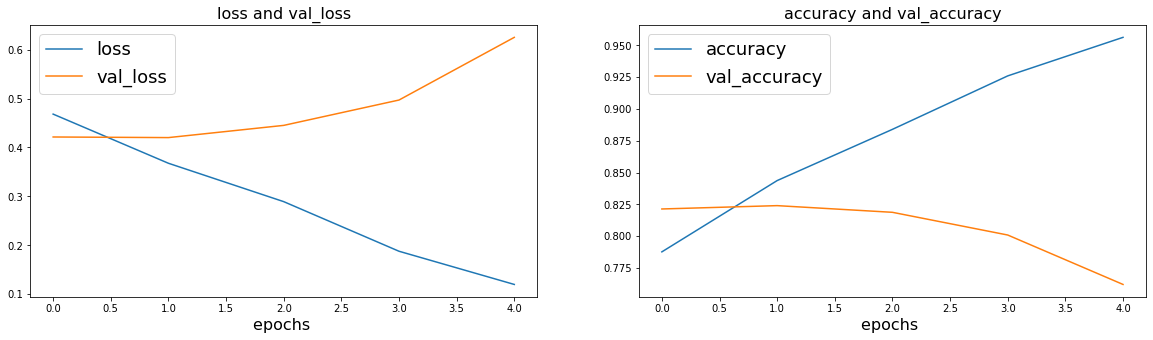

In [143]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('epochs ',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' and ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

#the baseline model shows after trained with 5 epochs, the accuracy is 95%, but overfitting may happens after 
#traine with 2 epochs, the val_accuracy and val_loss became unstable after 2 epochs

# Complete model

In [144]:
#Callback functions EarlyStopping, and ReduceLROnPlateau added
#Introducing more layers to imporve accuracy
#Dropout functions to prevent overfitting problem

early_stop = EarlyStopping(monitor='val_loss',patience=5,min_delta=0.0000001,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5, min_lr = 0.001)
    
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights = [embedding_matrix], input_length=length_long_sentence))
model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D()) #used for flatterning
model.add(BatchNormalization()) #standardizing the value, and speed up the training process
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(padded, targets, test_size=0.25, random_state = 42)
history = model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data = (X_test, y_test),verbose = 2, callbacks=[early_stop, reduce_lr])

Epoch 1/20
179/179 - 36s - loss: 0.6206 - accuracy: 0.7143 - val_loss: 0.5977 - val_accuracy: 0.7752
Epoch 2/20
179/179 - 34s - loss: 0.4911 - accuracy: 0.7837 - val_loss: 0.5135 - val_accuracy: 0.7883
Epoch 3/20
179/179 - 34s - loss: 0.4315 - accuracy: 0.8185 - val_loss: 0.4299 - val_accuracy: 0.8199
Epoch 4/20
179/179 - 32s - loss: 0.3814 - accuracy: 0.8413 - val_loss: 0.4625 - val_accuracy: 0.8104
Epoch 5/20
179/179 - 33s - loss: 0.3332 - accuracy: 0.8607 - val_loss: 0.4364 - val_accuracy: 0.8114
Epoch 6/20
179/179 - 33s - loss: 0.2814 - accuracy: 0.8956 - val_loss: 0.5060 - val_accuracy: 0.8009
Epoch 7/20
179/179 - 32s - loss: 0.2103 - accuracy: 0.9257 - val_loss: 0.5845 - val_accuracy: 0.7957
Epoch 8/20
179/179 - 32s - loss: 0.1690 - accuracy: 0.9380 - val_loss: 0.5367 - val_accuracy: 0.7936

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.001.


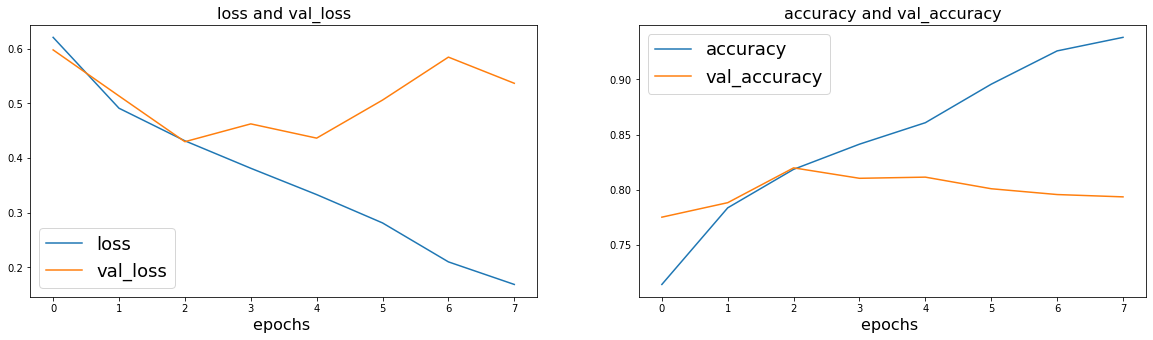

In [146]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('epochs ',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' and ' + arr[idx][1],fontsize=16)

plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
#after 4 epochs the val_loss gone up

In [147]:
from sklearn.metrics import classification_report

y_preds = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1091
           1       0.84      0.71      0.77       813

    accuracy                           0.82      1904
   macro avg       0.83      0.81      0.81      1904
weighted avg       0.82      0.82      0.82      1904



# Classical machine leanring models

In [148]:
#compare the rnn model with one of the classical machine learning models - naive_bayes
#based on the metrics F1, since the submissions are evaluated using F1 between the predicted and expected answers.

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(padded, targets, test_size=0.25, random_state = 42)

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_class = nb.predict(X_test)
y_pred_prob = nb.predict_proba(X_test)[:, 1]

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

#The navie bayes is performing badly compare to the deep learning model, it could due to the GloVe embedding used
#when preparing the train and test data, CountVectorizer from sklearn library does the job better in classical machine learning models

0.5672268907563025
[[758 333]
 [491 322]]
              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1091
           1       0.49      0.40      0.44       813

    accuracy                           0.57      1904
   macro avg       0.55      0.55      0.54      1904
weighted avg       0.56      0.57      0.56      1904



# Create Submission

In [149]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

test['text_clean'] = test['text'].apply(preprocess_data)
texts = test['text_clean']

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
vocab_length = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(texts)
padded_test = pad_sequences(sequences, padding='post')

In [150]:
y_preds = (model.predict(padded_test) > 0.5).astype("int32")
sub=pd.DataFrame({'id':submission['id'].values.tolist(),'target':y_preds.reshape(3263)})
sub.to_csv('submission_update.csv',index=False)